In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from lib.acoustic_model import AcousticModel
import lib.dataset as dataset
from lib.opt import optimize
import lib.media as media

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='0'

checkpoint_dir = '_whois'
window = 65536

In [7]:
train_set = dataset.WhoisDataset(root='data', train=True, window=window,
                                 translate=True, pitch_shift=5, jitter=1.0, stride=65536)
test_set = dataset.WhoisDataset(root='data', train=False, window=window, stride=1024)

Loaded dataset with 12031 datapoints
Loaded dataset with 18970 datapoints


In [8]:
class Model(AcousticModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def define_graph(self, debug=False):
        self.m = 1
        self.k = 512
        self.d = 1024
        self.stride = 1024
        self.regions = 1 + int(window - self.d)//self.stride
        
        self.wsin, self.wcos = self.create_filters(self.d,self.k)
        
        self.filters = filters = 128
        self.conv = nn.Sequential(
            nn.Conv2d(1,32,(129,1),padding=(64,0),bias=False),nn.BatchNorm2d(32,1),nn.ReLU(True),
            nn.Conv2d(32,32,(129,1),padding=(64,0),bias=False),nn.BatchNorm2d(32,32),nn.ReLU(True),
            nn.AvgPool2d((32,1),stride=(32,1)),
            nn.Conv2d(32,filters,3,padding=1,bias=False),nn.BatchNorm2d(filters,32),nn.ReLU(True),
            nn.Conv2d(filters,filters,3,padding=1,bias=False),nn.BatchNorm2d(filters,filters),nn.ReLU(True)
        )
        
        fc_capacity = 128
        self.out = nn.Sequential(
            nn.Linear(16*self.regions*self.filters,fc_capacity,bias=False),nn.ReLU(True),
            nn.Linear(fc_capacity,self.m,bias=True)
        )
    
    def forward(self, x, y):
        zx = F.conv1d(x[:,None,:], self.wsin, stride=self.stride).pow(2) \
           + F.conv1d(x[:,None,:], self.wcos, stride=self.stride).pow(2)
        return self.out(self.conv(torch.log(1+zx).unsqueeze(1)).view(-1,16*self.regions*self.filters))

In [9]:
model = Model(checkpoint_dir, avg=.9, pytorch_init=True)
model.initialize()

conv.0.weight torch.Size([32, 1, 129, 1]) (4128)
conv.1.weight torch.Size([32]) (32)
conv.1.bias torch.Size([32]) (32)
conv.3.weight torch.Size([32, 32, 129, 1]) (132096)
conv.4.weight torch.Size([32]) (32)
conv.4.bias torch.Size([32]) (32)
conv.7.weight torch.Size([128, 32, 3, 3]) (36864)
conv.8.weight torch.Size([128]) (128)
conv.8.bias torch.Size([128]) (128)
conv.10.weight torch.Size([128, 128, 3, 3]) (147456)
conv.11.weight torch.Size([128]) (128)
conv.11.bias torch.Size([128]) (128)
out.0.weight torch.Size([128, 131072]) (16777216)
out.2.weight torch.Size([1, 128]) (128)
out.2.bias torch.Size([1]) (1)
Initialized graph with 17098529 parameters


In [10]:
optimize(model,train_set,test_set,learning_rate=3e-4,batch_size=64,workers=4,alg='Adam')

Initiating optimizer, 188 iterations/epoch.
avp_tr	avp_ts	iter	loss_tr	loss_ts	time	utime
22.28   29.49   0       0.177   0.224   15.46   14.79   
82.05   82.92   188     0.060   0.079   100.74  15.48   
85.15   82.77   376     0.054   0.073   100.99  15.44   
85.18   79.94   564     0.054   0.081   101.02  15.49   
87.30   80.53   752     0.050   0.075   101.16  15.46   
87.38   78.53   940     0.051   0.081   101.41  15.76   
87.73   79.84   1128    0.048   0.085   101.08  15.48   
88.45   80.09   1316    0.046   0.079   101.61  15.82   
87.97   79.49   1504    0.047   0.078   101.38  15.62   
88.55   79.69   1692    0.045   0.083   101.46  15.79   
88.17   79.76   1880    0.046   0.083   101.42  15.73   
88.47   77.69   2068    0.045   0.088   101.31  15.65   
88.18   80.04   2256    0.045   0.077   101.30  15.70   
88.95   80.27   2444    0.045   0.079   101.51  15.85   
88.74   79.74   2632    0.045   0.085   100.96  15.25   
88.78   80.06   2820    0.046   0.078   101.54  15.73  

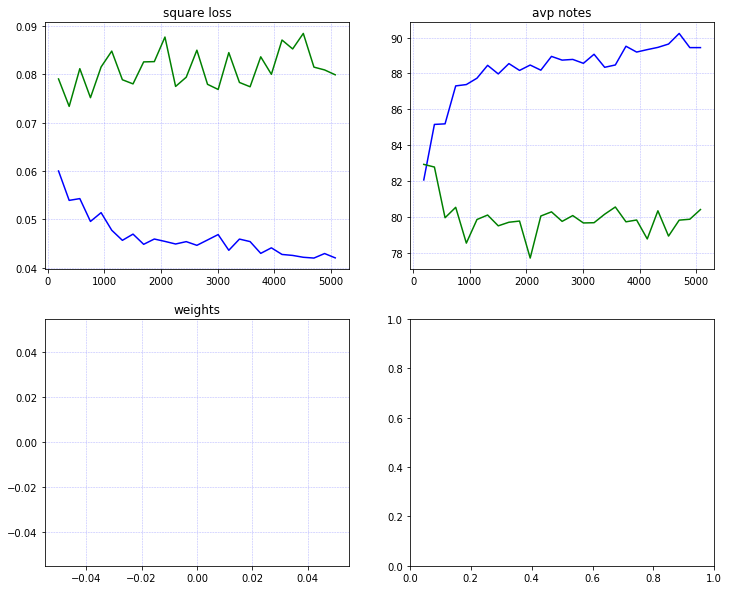

In [11]:
model.restore_checkpoint()
plt = media.PlotFormatter()
plt.plot('square loss',model.stats['loss_tr'][2],color='b')
plt.plot('square loss',model.stats['loss_ts'][2],color='g',share=True)
plt.plot('avp notes',model.stats['avp_tr'][2],color='b')
plt.plot('avp notes',model.stats['avp_ts'][2],color='g',share=True)
plt.plot('weights',model.sum_weights('beta'),color='g')
plt.show()

In [13]:
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=128,drop_last=False,num_workers=1)
yhat,y = model.predict_all(test_loader)

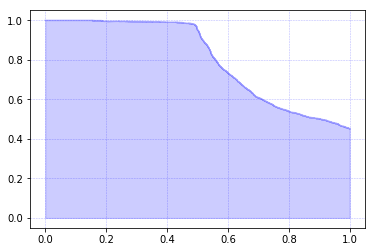

In [14]:
media.plot_pr_curve(y,yhat)

In [15]:
from sklearn.metrics import precision_recall_fscore_support
p,r,f,_ = precision_recall_fscore_support(y.ravel(),yhat.ravel()>.5,average='binary')
print(p,r,f)

0.6983458646616542 0.6285868976719003 0.6616327112124234
